In [1]:
# docker run --rm -it --platform linux/amd64 -p 8888:8888 -v "/Users/em/code/DeepASM/notebooks:/notebooks" us-east1-docker.pkg.dev/hmh-em-deepasm/docker-repo/python:${SHORT_SHA} jupyter notebook --ip=0.0.0.0 --no-browser --allow-root --NotebookApp.notebook_dir=/notebooks

import sys
import os
import io

from google.cloud import bigquery
from google.cloud import storage

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from hmmlearn.hmm import GaussianHMM
from sklearn.utils import check_random_state

rs = check_random_state(546)


In [2]:
# GCP authorization
files_in_directory = os.listdir()
json_files = [file for file in files_in_directory if file.endswith('.json')]

if json_files:
    print("JSON files found:", json_files)
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_files[0]
else:
    bq_client = bigquery.Client()

In [3]:
# Variables
PROJECT_ID = "hmh-em-deepasm"
BQ_ML_DATASET = "hg19_250_ml"

## Download data from BQ

In [4]:
query = f"SELECT directional_cpg_frac FROM {PROJECT_ID}.{BQ_ML_DATASET}.TRAINING"

# Execute Query and store as DF
df = bq_client.query(query).to_dataframe()

In [5]:
df

,directional_cpg_frac
0,"[0.0, -0.05, -0.05, -0.05, 0.0, -0.2, -0.05, -..."
1,"[-0.05, -0.05, 0.0, 0.0, 0.0, 0.0, -0.45, 0.0,..."
2,"[-0.15, -0.15, -0.05, 0.0, -0.05, 0.0, -0.1, 0.0]"
3,"[-0.1, 0.0, 0.0, 0.0, -0.2, 0.05, 0.0, 0.0]"
4,"[-0.1, 0.05, 0.0, -0.15, -0.1, -0.05, -0.1, 0.15]"
...,...
1438315,"[-0.4, -0.4, -0.2, -0.2, -0.05]"
1438316,"[-0.05, -0.4, -0.1, -0.2, -0.05]"
1438317,"[-0.4, -0.15, -0.25, -0.15, -0.05]"
1438318,"[0.0, -0.2, -0.25, -0.25, -0.1]"


In [6]:
all_obs = np.concatenate(df['directional_cpg_frac'].tolist())

In [7]:
def prepare_data_for_hmm(sequence):
    """
    Prepares a sequence of data for processing with a Hidden Markov Model (HMM).

    This function ensures the input sequence is in a 2D NumPy array format required by HMM processing routines, handling both single-dimensional sequences (interpreting them as a sequence of scalar observations) and two-dimensional sequences (interpreting them as a sequence of vector observations). It also calculates the length of the sequence, which is necessary for some HMM algorithms.

    Parameters:
    - sequence (np.ndarray): The input sequence to be processed. This can be either a 1D array of scalar observations or a 2D array of vector observations, where each row represents a timestep.

    Returns:
    - sequence (np.ndarray): The input sequence reshaped into a 2D NumPy array format, with individual observations along rows.
    - lengths (list of int): A list containing a single integer, which is the length of the input sequence. This is used by HMM algorithms that require the lengths of sequences being processed.

    Raises:
    - ValueError: If the input `sequence` has more than two dimensions, indicating it's not in an acceptable format for HMM processing.
    """

    if sequence.ndim == 1:
        sequence = np.atleast_2d(sequence).T
    elif sequence.ndim > 2:
        raise ValueError(
            "Sequence must be 1D (for single float sequence) or 2D (for sequence of vectors)"
        )

    # Determine the length of the sequence dynamically
    sequence_length = sequence.shape[0]

    # For a single sequence, the lengths list contains just one element: the sequence length
    lengths = [sequence_length]

    return sequence, lengths

In [8]:
reshaped_data, lengths = prepare_data_for_hmm(all_obs)

In [16]:
aic = []
bic = []
lls = []
ns = [1,2, 3, 4, 5, 6, 7]
for n in ns:
    print(f"Number of states: {n}")
    best_ll = None
    best_model = None
    for i in range(5):
        print(f"Iteration: {i}")
        h = GaussianHMM(n,
                        n_iter=200,
                        covariance_type = 'tied',
                        algorithm = 'viterbi',
                        random_state=rs) # tol=1e-4,
        h.fit(reshaped_data, lengths)
        score = h.score(reshaped_data)
        print(f"score: {score}")
        if not best_ll or best_ll < best_ll:
            best_ll = score
            best_model = h
    aic.append(best_model.aic(reshaped_data))
    bic.append(best_model.bic(reshaped_data))
    lls.append(best_model.score(reshaped_data))

Number of states: 1
Iteration: 0
score: 3088227.45542628
Iteration: 1
score: 3088227.45542628
Iteration: 2
score: 3088227.45542628
Iteration: 3
score: 3088227.45542628
Iteration: 4
score: 3088227.45542628
Number of states: 2
Iteration: 0
score: 4130334.192013775
Iteration: 1
score: 3924526.271894181
Iteration: 2
score: 4130334.191118554
Iteration: 3
score: 4130334.1923655737
Iteration: 4
score: 4130334.190850579
Number of states: 3
Iteration: 0
score: 3088227.4342335234
Iteration: 1
score: 4658822.862373417
Iteration: 2
score: 3088227.272562782
Iteration: 3
score: 4658822.859259206
Iteration: 4
score: 4658822.865500716
Number of states: 4
Iteration: 0
score: 4789006.314799864
Iteration: 1
score: 4723794.540147371
Iteration: 2
score: 4789007.516394458
Iteration: 3
score: 4727399.760635351
Iteration: 4
score: 4658830.692364648
Number of states: 5
Iteration: 0
score: 4788287.632045612
Iteration: 1
score: 4659406.323597919
Iteration: 2
score: 4859917.777301647
Iteration: 3
score: 4692570.5

In [27]:
ns = [8,9,10]
for n in ns:
    print(f"Number of states: {n}")
    best_ll = None
    best_model = None
    for i in range(5):
        print(f"Iteration: {i}")
        h = GaussianHMM(n,
                        n_iter=200,
                        covariance_type = 'tied',
                        algorithm = 'viterbi',
                        random_state=rs) # tol=1e-4,
        h.fit(reshaped_data, lengths)
        score = h.score(reshaped_data)
        print(f"score: {score}")
        if not best_ll or best_ll < best_ll:
            best_ll = score
            best_model = h
    aic.append(best_model.aic(reshaped_data))
    bic.append(best_model.bic(reshaped_data))
    lls.append(best_model.score(reshaped_data))

Number of states: 8
Iteration: 0
score: 5015177.084851294
Iteration: 1
score: 4958438.2232393725
Iteration: 2
score: 5068177.643957599
Iteration: 3
score: 4896766.021240527
Iteration: 4
score: 4925212.284944063
Number of states: 9
Iteration: 0
score: 5076289.866246521
Iteration: 1
score: 5051988.030124573
Iteration: 2
score: 4918474.790372684
Iteration: 3
score: 4919249.353968496
Iteration: 4
score: 4995350.666189302
Number of states: 10
Iteration: 0
score: 4975394.650177621
Iteration: 1
score: 4963726.425155022
Iteration: 2
score: 5055807.003306751
Iteration: 3
score: 5017956.335247347
Iteration: 4
score: 5044471.302428006


In [28]:
aic

[-6176450.91085256,
 -8260656.38402755,
 -6176430.868467047,
 -9577972.629599728,
 -9576515.264091223,
 -9480308.870166129,
 -9873611.989808822,
 -10030210.169702588,
 -10152399.732493041,
 -9950569.300355243]

In [29]:
bic

[-6176423.447105062,
 -8260573.992785056,
 -6176266.085982059,
 -9577697.992124747,
 -9576103.307878753,
 -9479732.13146867,
 -9872843.004878879,
 -10029221.47479266,
 -10151163.863855632,
 -9949058.794242853]

In [30]:
lls

[3088227.45542628,
 4130334.192013775,
 3088227.4342335234,
 4789006.314799864,
 4788287.632045612,
 4740196.435083064,
 4936861.994904411,
 5015177.084851294,
 5076289.866246521,
 4975394.650177621]

In [32]:
ns = [1,2,3,4,5,6,7,8,9,10]

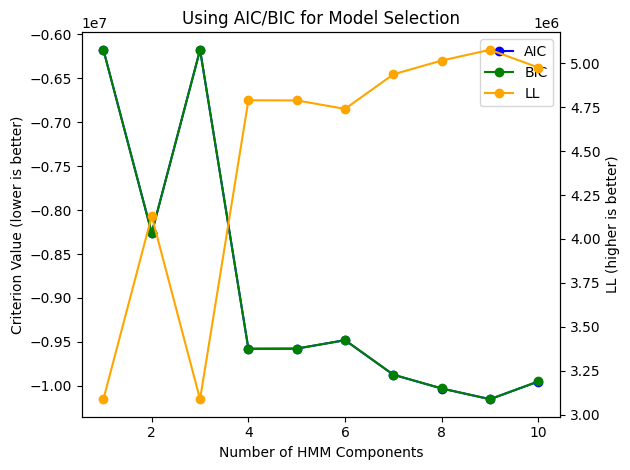

In [33]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

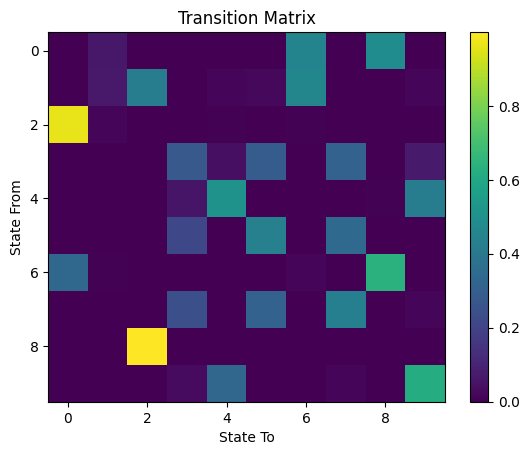

In [34]:
# Assuming best_model.transmat_ is defined and contains the transition matrix you want to plot
# Create the figure and axis
fig, ax = plt.subplots()

# Plot the transition matrix
cax = ax.imshow(best_model.transmat_, aspect='auto')

# Create a colorbar with a reference to the imshow plot
fig.colorbar(cax)

# Set the title and labels
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')

# Display the plot
plt.show()

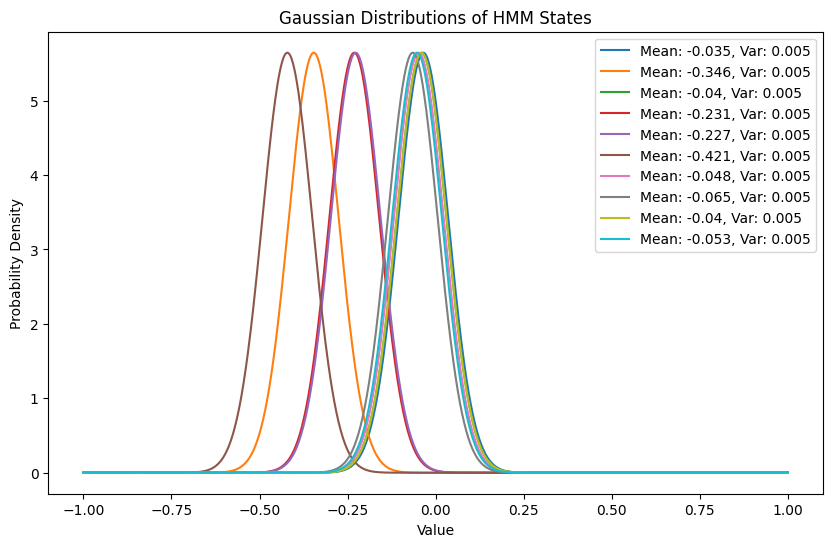

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Example Gaussian parameters for 5 states
means = np.round(best_model.means_.flatten(),3)  # [1, 3, 5, 7, 9]
covariances = np.round(best_model.covars_.flatten(),3) #[0.5, 0.2, 1.0, 0.3, 0.7]  # Variance in this case

# Create a figure
plt.figure(figsize=(10, 6))

# Value range for x-axis
x = np.linspace(-1, 1, 1000)

# Plot each Gaussian
for mean, cov in zip(means, covariances):
    plt.plot(x, norm.pdf(x, mean, np.sqrt(cov)), label=f'Mean: {mean}, Var: {cov}')

plt.title('Gaussian Distributions of HMM States')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

plt.show()